## Mini Project
### Python in ML
### Amir- 2022

In [1]:
''' 
1- Use Nice_smaller image data set
2- There are 2 classes, Male and Female
3- There are 518 images per class
4- Develop a deep learning classifier
5- Use 90% of images for training and 10% for testing and evaluation
6- Complete the table below by changing the deep learning config 
(number of layers, number of neurons, activation function, and so on) 3 times, 
and report the accuracy, precision, and recall
7- Set the training epochs to 10
8- If you've got enough time, increase the training epochs to 60 and repeat the tests

Change batch size from 16 to 24 to 36
Validation splot 0.2 0.1 0.3
Report last val_accuracy
'''

" \n1- Use Nice_smaller image data set\n2- There are 2 classes, Male and Female\n3- There are 518 images per class\n4- Develop a deep learning classifier\n5- Use 90% of images for training and 10% for testing and evaluation\n6- Complete the table below by changing the deep learning config \n(number of layers, number of neurons, activation function, and so on) 3 times, \nand report the accuracy, precision, and recall\n7- Set the training epochs to 10\n8- If you've got enough time, increase the training epochs to 60 and repeat the tests\n\nChange batch size from 16 to 24 to 36\nValidation splot 0.2 0.1 0.3\nReport last val_accuracy\n"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-10-14 15:13:34.910985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 15:13:35.494828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/melodic/lib
2022-10-14 15:13:35.494856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-14 15:13:35.606320: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-14 15:13:37.307001: W

In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


2022-10-14 15:13:39.469851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 15:13:39.494625: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-14 15:13:39.494699: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mpheng-Lenovo-ideapad-520-15IKB): /proc/driver/nvidia/version does not exist


In [4]:
image_size = (180, 180)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "nice_smaller",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "nice_smaller",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1036 files belonging to 2 classes.
Using 829 files for training.
Found 1036 files belonging to 2 classes.
Using 207 files for validation.


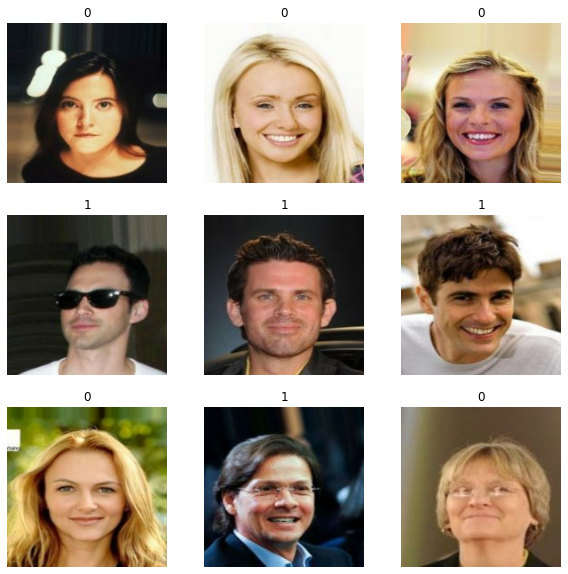

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

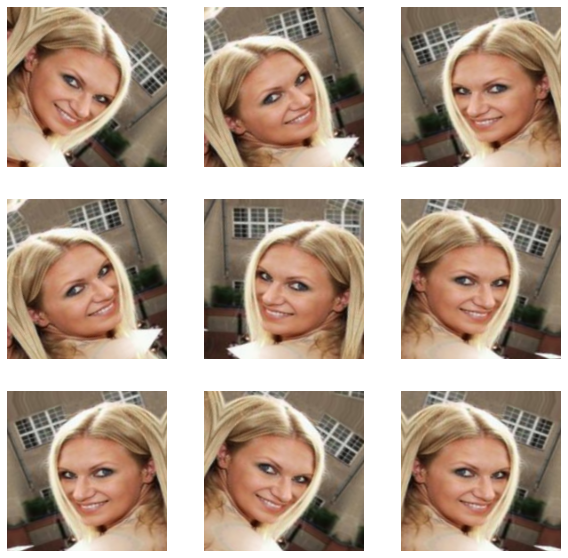

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [11]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
epochs = 10

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/10
52/52 [==============================] - 85s 2s/step - loss: 0.6984 - accuracy: 0.6273 - val_loss: 0.6944 - val_accuracy: 0.4783
Epoch 2/10
52/52 [==============================] - 85s 2s/step - loss: 0.6119 - accuracy: 0.6948 - val_loss: 0.7245 - val_accuracy: 0.4783
Epoch 3/10
52/52 [==============================] - 82s 2s/step - loss: 0.5918 - accuracy: 0.6996 - val_loss: 0.7251 - val_accuracy: 0.4783
Epoch 4/10
52/52 [==============================] - 88s 2s/step - loss: 0.5547 - accuracy: 0.7177 - val_loss: 0.7171 - val_accuracy: 0.4783
Epoch 5/10
52/52 [==============================] - 91s 2s/step - loss: 0.5600 - accuracy: 0.7201 - val_loss: 0.6960 - val_accuracy: 0.4831
Epoch 6/10
52/52 [==============================] - 91s 2s/step - loss: 0.5178 - accuracy: 0.7467 - val_loss: 0.6887 - val_accuracy: 0.5217
Epoch 7/10
52/52 [==============================] - 92s 2s/step - loss: 0.5015 - accuracy: 0.7600 - val_loss: 0.6740 - val_accuracy: 0.6039
Epoch 8/10
52/52 [==

In [ ]:
img = keras.preprocessing.image.load_img(
    "petsmallest/Cat/0.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

Test    	Deep learning system Config     	Accuracy    	 Precision      	Recall

1

2				

3

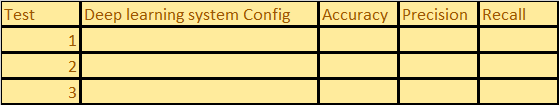